<a href="https://colab.research.google.com/github/AFBA1993/Projects/blob/main/TemporalSeries/PAGS/PAGS_predicting_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from keras.metrics import mean_squared_error
from keras.models import load_model

In [2]:
url = ('https://raw.githubusercontent.com/AFBA1993/Projects/main/'+
       'TemporalSeries/PAGS/PAGSattempt.csv')

In [3]:
url_data = requests.get(url).content
raw_data = pd.read_csv(io.StringIO(url_data.decode('utf-8')))

In [4]:
raw_data = raw_data[["Date","Close"]]
raw_data.index = pd.to_datetime(raw_data["Date"])
raw_data.drop("Date", axis = 1, inplace =  True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
SPLIT_PERCENT = 0.80
split = int(SPLIT_PERCENT*len(raw_data))
train = raw_data[:split]
test = raw_data[split:]

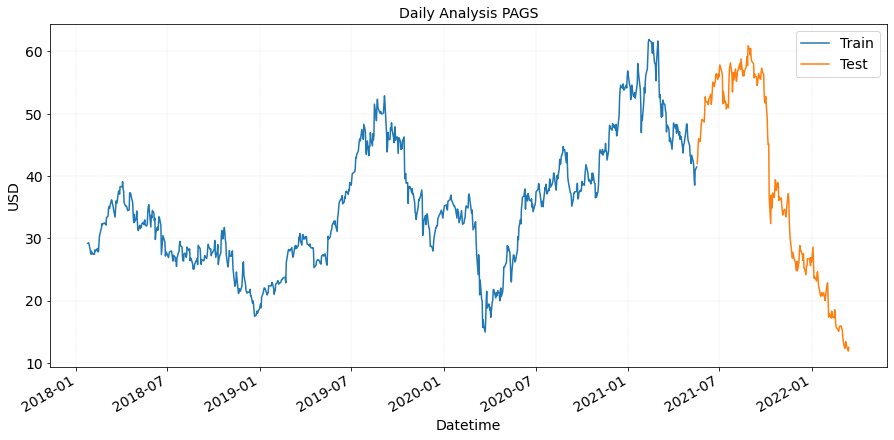

In [6]:
FONTSIZE = 14
plt.title('Daily Analysis PAGS', fontsize = FONTSIZE )
train.Close.plot(figsize = (15,7), label = 'Train', fontsize =FONTSIZE)
test.Close.plot(figsize = (15,7), label = 'Test', fontsize =FONTSIZE)
plt.xlabel('Datetime', fontsize =FONTSIZE)
plt.ylabel('USD', fontsize =FONTSIZE)
plt.legend(loc = 'best', fontsize =FONTSIZE)
plt.grid(color = 'lightgray' , linestyle = '--', lw = '.3')

In [7]:
model_3 = load_model('/content/drive/MyDrive/STOCK PRIZES/model_3.h5')

In [8]:
input_train = train.values
input_train = input_train.reshape((-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
input_train = scaler.fit_transform(input_train)

In [9]:
LOOK_BACK = 100
X_train = []
y_train = []

## **PREDICTING INTERVAL IN TRAIN DATASET:**

In [10]:
for i in range (LOOK_BACK, len(input_train)):
  X_train.append(input_train[i-LOOK_BACK:i,0])
  y_train.append(input_train[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], LOOK_BACK, 1))

In [11]:
yhat_train = (model_3.predict(X_train))

In [12]:
yhat_train = scaler.inverse_transform(yhat_train)

In [13]:
df = pd.DataFrame()

In [14]:
df['actual'] = train.Close[LOOK_BACK:].values

In [15]:
df['predicts'] = yhat_train

In [16]:
df['error'] = df.actual-df.predicts

In [ ]:
df

,actual,predicts,error
0,32.099998,33.717930,-1.617932
1,27.400000,32.947529,-5.547529
2,28.490000,29.701500,-1.211500
3,29.430000,28.587151,0.842849
4,30.450001,29.122925,1.327076
...,...,...,...
729,41.779999,43.641205,-1.861206
730,39.619999,42.910030,-3.290031
731,38.540001,41.121250,-2.581249
732,40.980000,39.796829,1.183171


errors description: count    734.000000
mean      -0.432281
std        1.397753
min       -7.004619
25%       -1.176233
50%       -0.343761
75%        0.373462
max        4.395577
Name: error, dtype: float64


Text(0.5, 1.0, 'Error')

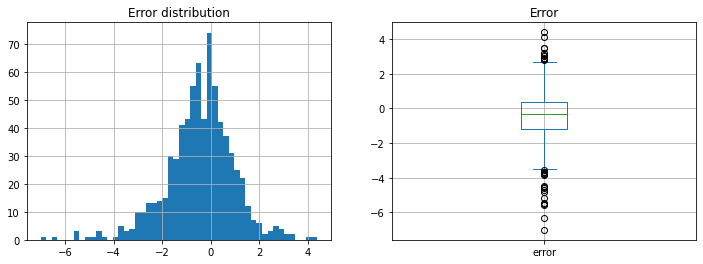

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
print("errors description:", df.error.describe())
df.error.hist(bins=50).set_title('Error distribution')
plt.subplot(122)
df.error.plot(kind='box', grid=True).set_title("Error")

In [18]:
err_std = df.error.std(axis=0)
err_mean = df.error.mean(axis=0)

In [19]:
err_std

1.3977531638804979

In [24]:
look_back = 600
std_part = 1.0  # use values from 0 to 1 if you have an idea what part of STD should be used.
act_lb = df.actual[-look_back:].values
pred_lb = df.predicts[-look_back:].values
err_std = df.error.std(axis=0)
err_mean = df.error.mean(axis=0)
pred_upper = pred_lb + err_mean + err_std * std_part
pred_lower = pred_lb + err_mean - err_std * std_part
err_x = np.linspace(0, len(act_lb)-1, len(act_lb))


In [21]:
err_x.shape

(500,)

In [22]:
pred_lower.shape, pred_upper.shape

((500,), (500,))

Text(0.5, 1.0, 'Actual vs Predicts. Last 600 values')

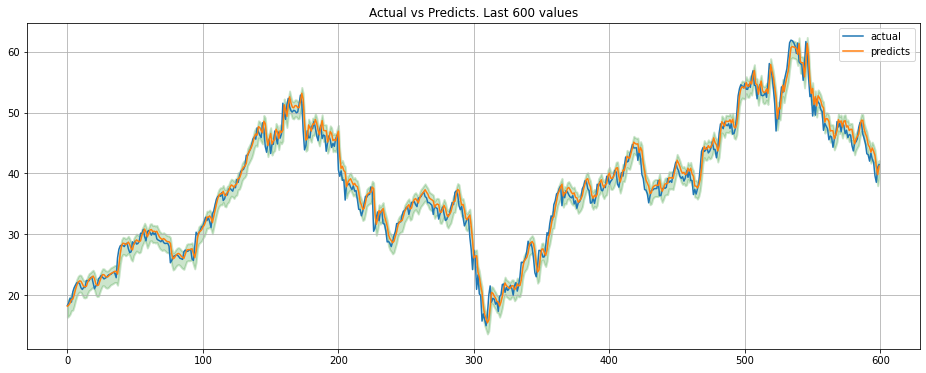

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(act_lb[-look_back:], label='actual')
plt.plot(pred_lb[-look_back:], label='predicts')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. Last {} values'.format(look_back))


## **PREDICTING INTERVAL IN TEST DATASET:**

In [26]:
complete_data = raw_data.values
input_test = complete_data[len(complete_data) - len(test) - LOOK_BACK:]
input_test = input_test.reshape((-1, 1))
input_test = scaler.transform(input_test)

In [27]:
X_test = []
for i in range(LOOK_BACK, len(input_test)):
  X_test.append(input_test[i-LOOK_BACK:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [28]:
yhat_test = model_3.predict(X_test)
yhat_test = scaler.inverse_transform(yhat_test)

In [29]:
df_test = pd.DataFrame()
df_test['actual'] = test.Close.values
df_test['predicts'] = yhat_test
df_test['error'] = df_test.actual-df_test.predicts

errors description: count    209.000000
mean      -0.541995
std        1.611979
min       -9.936355
25%       -1.221182
50%       -0.443691
75%        0.502315
max        3.592216
Name: error, dtype: float64


Text(0.5, 1.0, 'Error')

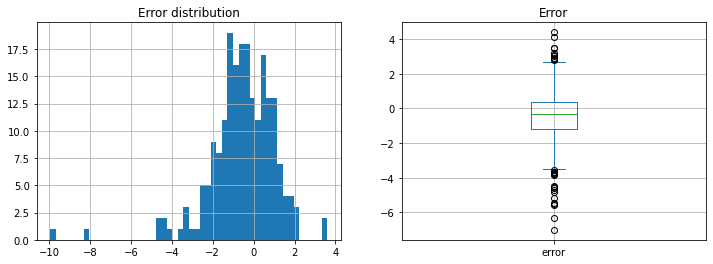

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
print("errors description:", df_test.error.describe())
df_test.error.hist(bins=50).set_title('Error distribution')
plt.subplot(122)
df.error.plot(kind='box', grid=True).set_title("Error")

In [31]:
std_part = 1.0  # use values from 0 to 1 if you have an idea what part of STD should be used.
act_lb = df_test.actual[-look_back:].values
pred_lb = df_test.predicts[-look_back:].values
err_std = df_test.error.std(axis=0)
err_mean = df_test.error.mean(axis=0)
pred_upper = pred_lb + err_mean + err_std * std_part
pred_lower = pred_lb + err_mean - err_std * std_part
err_x = np.linspace(0, len(act_lb)-1, len(act_lb))

Text(0.5, 1.0, 'Actual vs Predicts. Test section')

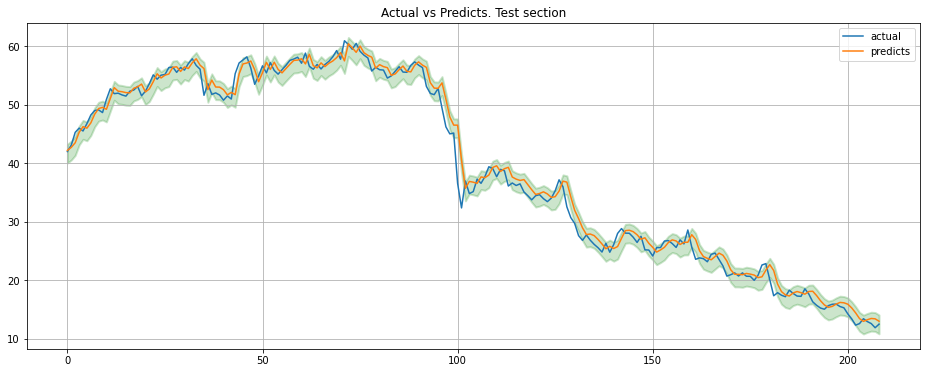

In [36]:
plt.figure(figsize=(16, 6))
plt.plot(act_lb, label='actual')
plt.plot(pred_lb, label='predicts')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. Test section')

## **PREDICTING INTERVAL FORECAST:**

Loading actual data:

In [70]:
url_actual = ('https://raw.githubusercontent.com/AFBA1993/Projects/main/' + 
       'TemporalSeries/PAGS/PAGS_16.csv')
url_actual = requests.get(url_actual).content
raw_actual = pd.read_csv(io.StringIO(url_actual.decode('utf-8')))

raw_actual = raw_actual[["Date","Close"]]
raw_actual
raw_actual.index = pd.to_datetime(raw_actual["Date"])
raw_actual.drop("Date", axis = 1, inplace =  True)

Forecasting values:

In [38]:
FORECAST_DAYS = 200
forecasted_lst = []

In [40]:
input_forecast = test[len(test) - LOOK_BACK :].values
input_forecast = scaler.fit_transform(input_forecast)
input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))

In [41]:
for i in range(FORECAST_DAYS):
  forecast = model_3.predict(input_forecast)
  forecasted_lst.append(forecast)
  input_forecast = np.reshape(input_forecast, (input_forecast.shape[1], 1))
  input_forecast = np.concatenate((input_forecast,forecast))
  input_forecast = input_forecast[-LOOK_BACK:]
  input_forecast = np.reshape(input_forecast, (1, LOOK_BACK,1))

In [42]:
forecasted_lst = np.array(forecasted_lst)
forecasted_lst = forecasted_lst.reshape((-1, 1))
forecasted_lst = scaler.inverse_transform(forecasted_lst)

In [43]:
last_test_date = test.index[-1]
initial_forecast_date = pd.date_range(last_test_date, periods = 2, freq='D' )
initial_forecast_date = initial_forecast_date[-1]

In [44]:
forecast_dates = pd.date_range(initial_forecast_date, periods = 
                                      FORECAST_DAYS, freq='D')

In [45]:
LSTM_forecast = pd.DataFrame(forecasted_lst, columns = ['Close'])
LSTM_forecast["Date"] = forecast_dates
LSTM_forecast.index = LSTM_forecast["Date"]
LSTM_forecast.drop("Date", axis = 1, inplace =  True)

In [79]:
pred_upper = LSTM_forecast.Close + err_mean*0 + 1.96* err_std * std_part
pred_lower = LSTM_forecast.Close + err_mean*0 - 1.96* err_std * std_part
pred_lb = LSTM_forecast
err_x = LSTM_forecast.Close.index

In [64]:
err_x

DatetimeIndex(['2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25',
               ...
               '2022-09-22', '2022-09-23', '2022-09-24', '2022-09-25',
               '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29',
               '2022-09-30', '2022-10-01'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)

Text(0.5, 1.0, 'Actual vs Forecasted')

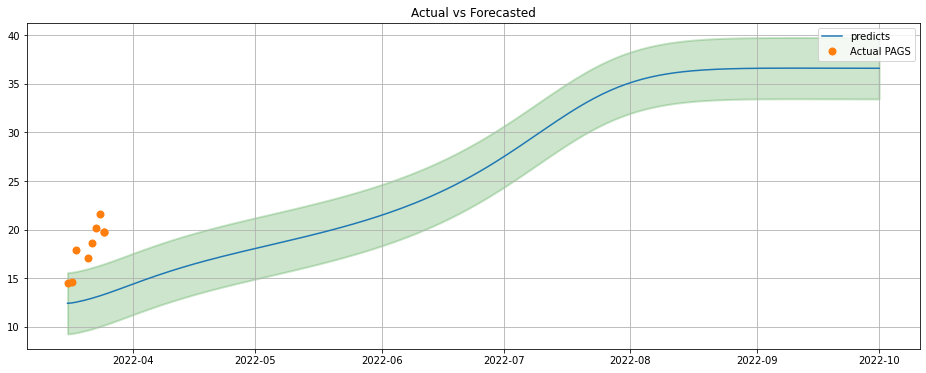

In [80]:
plt.figure(figsize=(16, 6))
plt.plot(pred_lb, label='predicts')
#plt.plot(pred_upper, label='Upper')
plt.plot(raw_actual.Close, label='Actual PAGS',ls = 'None', marker = 'o', mew = 2)
plt.fill_between(x=err_x, y1=pred_upper.values, y2=pred_lower.values, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Actual vs Forecasted')